## Summary

This EDA served as data cleaning and feature engineering purposes. Two datasets were generated with the first carrying only features provided by the raw dataset, and the second with additional features engineered in this EDA.

## TOC

1. [Basic EDA and Data cleaning](#Basic-EDA-and-Data-cleaning)
 - basic numerical EDA, statistical descriptions were not presented.
 - some categorical features were regrouped to reduce imbalance.
 - the first dataset was all up to this point.
2. [More EDA](#More-EDA)
 - insights that might help model building and feature engineering
3. [EDA that leads to new features](#EDA-that-leads-to-new-features)
 - feature engineered was intended to be metrics understandable by non-technical, and had a trend with the predicting variable
 - the second dataset was all up to this point.
4. [Correlations and distributions visualization](#Correlations-and-distributions-visualization)
 - to see how good/bad the features were distributed and correlated with the predicting variable
5. [Business porfolio](#Business-porfolio)
 - a porfolio snapshot in August 2015
 - generated for evaluating the expected ROI of the model trained. Not a full porfolio analysis.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# constants
LABEL = 'default.payment.next.month'
OVERDUE_INTEREST = 0.015

In [2]:
data = pd.read_csv('./dataset/data.csv')
print(data.shape)

(10000, 26)


## Basic EDA and Data cleaning
[Back to top](#TOC)

In [3]:
# Remove (unspecified) MARRIAGE=0 or EDUCATION=0
data = data[(data['MARRIAGE']!=0) & (data['EDUCATION']!=0)]

# Check ID uniqueness
print('===ID uniqueness', data['ID'].nunique() == data.shape[0])

# Visualize categorical variables' distributions
print('===Categorical variables distributions')
display(pd.concat([data[c].value_counts() for c in ['SEX', 'MARRIAGE', 'EDUCATION']], axis=1).fillna(''))

# Remove imbalanced categories and one-hot encode them.
# a. recategorize MARRIAGE into 1-married 0-non-married (single and others)
data['MARRIAGE'] = data['MARRIAGE'].map({1:1, 2:0, 3:0}).astype(float)

# b. make 3 features for EDUCATION
data['EDUCATION_GRAD'] = (data['EDUCATION'] == 1).astype(float)
data['EDUCATION_UNIV'] = (data['EDUCATION'] == 2).astype(float)
data['EDUCATION_OTHERS'] = (~data['EDUCATION'].isin([1,2])).astype(float)

# Visualize PAY_X distribution
print('===PAY_X distributions')
display(pd.concat([data[c].value_counts() for c in data.filter(regex='PAY_[0-9]')], axis=1).fillna(''))
print('''PAY_0 has a very different distribution, possibly because the data was collected 
close to the end of October 2015 so that for some customers the payment for September had
not been due yet and payment status remained "undecided" between a payment missing or fulfillment.
For such uncertainty, PAY_0 will not be used.
''')

# Remove unused columns
data = data.drop(columns=['PAY_0', 'PAY_1', 'EDUCATION', 'ID'])

# Save the first dataset
data.to_csv('data_original_features.csv', index=False)

===ID uniqueness True
===Categorical variables distributions


,SEX,MARRIAGE,EDUCATION
1,3970.0,4474.0,3513
2,6009.0,5281.0,4582
3,,224.0,1624
4,,,46
5,,,90
6,,,124


===PAY_X distributions


,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_1
-2.0,901,1259.0,1340.0,1418.0,1498.0,1620.0,
-1.0,1890,2025.0,1999.0,1925.0,1859.0,1912.0,
0.0,4913,5262.0,5335.0,5525.0,5653.0,5437.0,100.0
1.0,1255,7.0,1.0,1.0,,,
2.0,877,1258.0,1179.0,990.0,864.0,913.0,
3.0,101,121.0,76.0,65.0,55.0,56.0,
4.0,25,30.0,24.0,24.0,26.0,13.0,
5.0,7,8.0,11.0,10.0,3.0,5.0,
6.0,4,5.0,4.0,,2.0,8.0,
7.0,2,4.0,10.0,21.0,19.0,15.0,


PAY_0 has a very different distribution, possibly because the data was collected 
close to the end of October 2015 so that for some customers the payment for September had
not been due yet and payment status remained "undecided" between a payment missing or fulfillment.
For such uncertainty, PAY_0 will not be used.



## More EDA
[Back to top](#TOC)

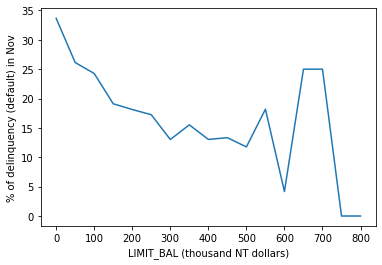

- (non-linear) decreasing trend of delinquency (default) as LIMIT_BAL goes up.
- Variation at the tail can be due to low statistics.
- Could be an evident that the evaluated LIMIT_BAL was not bad



In [4]:
(data.groupby((data['LIMIT_BAL']/50000).astype(int)*50)[LABEL]\
    .mean()*100)\
    .plot(
        xlabel='LIMIT_BAL (thousand NT dollars)',
        ylabel='% of delinquency (default) in Nov'
    )
plt.show()
print('''- (non-linear) decreasing trend of delinquency (default) as LIMIT_BAL goes up.
- Variation at the tail can be due to low statistics.
- Could be an evident that the evaluated LIMIT_BAL was not bad
''')

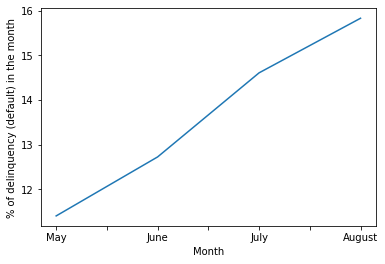

- delinquency (default) rate went up with month. Looks linear here but could become non-linear when more months are available to take seasonality into account. This is a signal that model has to be updated from time to time to reflect the changed systematics.



In [5]:
payment_missing_rate = {
    'May': (data[data['BILL_AMT6']>0]['PAY_5']>0).mean(),
    'June': (data[data['BILL_AMT5']>0]['PAY_4']>0).mean(),
    'July': (data[data['BILL_AMT4']>0]['PAY_3']>0).mean(),
    'August': (data[data['BILL_AMT3']>0]['PAY_2']>0).mean(),
}
(pd.Series(payment_missing_rate)*100).plot(
        xlabel='Month',
        ylabel='% of delinquency (default) in the month'
)
plt.show()

print('''- delinquency (default) rate went up with month. Looks linear here but could become non-linear when more months are available to take seasonality into account. This is a signal that model has to be updated from time to time to reflect the changed systematics.
''')

In [6]:
c = data.filter(regex='PAY_[0-9]').columns
df = pd.concat(
    [data[[c1,c2]].rename(columns={c1:'from', c2:'to'}) for c1, c2 in zip(c[1:], c)]
)

m = {-2: 'Good-Full Paid', -1: 'Good-Full Paid', 0: 'Good-Partial Paid'}

df['from1'] = df['from'].map(m).fillna('Bad-Missed')
df['from2'] = df['from1'].str.split('-', expand=True)[0]

df['to1'] = df['to'].map(m).fillna('Bad-Missed')
df['to2'] = df['to1'].str.split('-', expand=True)[0]

transition = df.groupby(['to','from']).size().unstack(fill_value=0)
transition1 = df.groupby(['to1','from1']).size().unstack(fill_value=0)
transition2 = df.groupby(['to2','from2']).size().unstack(fill_value=0)

display(transition1)
display(transition2)

print(f'''Payment status transition matrix between April and August
- {round(19485/(19485+1160+1305)*100,1)}% Partial paid remained the same state in the next month
- {round(1673/(1673+33848)*100,1)}% Good state changed to Bad state
- {round(1250/(1250+3145)*100,1)}% Bad state changed to Good state
''')

from1,Bad-Missed,Good-Full Paid,Good-Partial Paid
to1,,,
Bad-Missed,3145,368,1305
Good-Full Paid,320,11843,1160
Good-Partial Paid,930,1360,19485


from2,Bad,Good
to2,,
Bad,3145,1673
Good,1250,33848


Payment status transition matrix between April and August
- 88.8% Partial paid remained the same state in the next month
- 4.7% Good state changed to Bad state
- 28.4% Bad state changed to Good state



# EDA that leads to new features
[Back to top](#TOC)

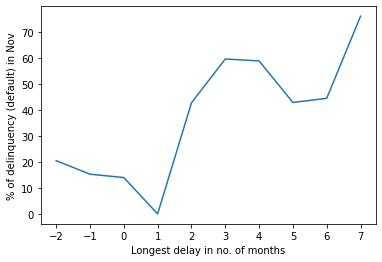

- Higher chance of delinquency (default) for worse record customers.
*** New ordinal feature LONGEST_DELAY:
0: Never
1: 1-2 months
2: >2 months



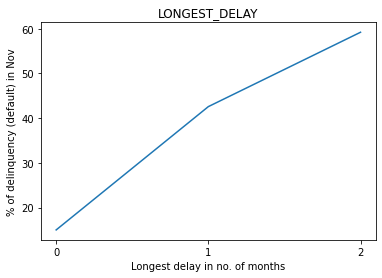

In [7]:
df = data.filter(regex='PAY_[0-9]').max(axis=1)
(data.groupby(df)[LABEL]\
    .mean()*100)\
    .plot(
        xticks=list(range(-2,8)),
        xlabel='Longest delay in no. of months',
        ylabel='% of delinquency (default) in Nov'
    )
plt.show()
print('''- Higher chance of delinquency (default) for worse record customers.
*** New ordinal feature LONGEST_DELAY:
0: Never
1: 1-2 months
2: >2 months
''')

data['LONGEST_DELAY'] = df.map({
    -2:0, -1:0, 0:0,
    1: 1, 2: 1,
}).fillna(2)

(data.groupby('LONGEST_DELAY')[LABEL]\
    .mean()*100)\
    .plot(
        xticks=[0,1,2],
        title='LONGEST_DELAY',
        xlabel='Longest delay in no. of months',
        ylabel='% of delinquency (default) in Nov'
    )
plt.show()

% of delinquency (default) in November
NoBadMonths: how many months with a delinquency (default) status
BadMonthProximity: what is the lastest month with a delinquency (default) status



NoBadMonths,0,1,2,3,4,5
BadMonthProximity,,,,,,
August,,41.6,49.8,57.7,61.8,68.3
July,,27.3,24.1,55.2,34.4,
June,,28.7,52.4,41.2,,
May,,32.7,35.8,,,
April,,22.5,,,,
Before April,15.0,,,,,


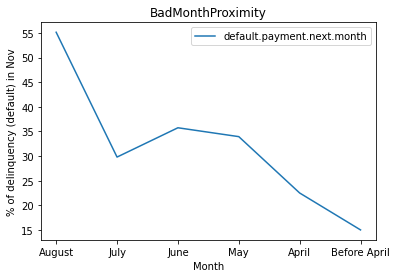

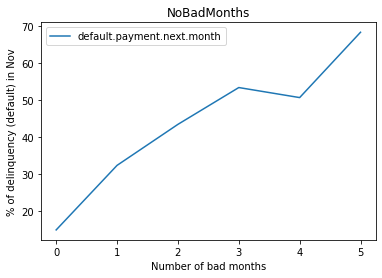


- Higher delinquency (default) rate when the number of bad months is higher
- Higher delinquency (default) rate when the latest delinquency month is closer (This may not be true for predicting other months if seasonality exists)

*** New features BAD_MONTH_PROXIMITY, NO_BAD_MONTHS



In [8]:
m = dict(enumerate(['August', 'July', 'June', 'May', 'April', 'Before April']))
df = pd.concat([
        (data.filter(regex='PAY_[0-9]') < 1).cumprod(axis=1).sum(axis=1).map(m).rename('BadMonthProximity'),
        (data.filter(regex='PAY_[0-9]') > 0).sum(axis=1).rename('NoBadMonths'),
        data[LABEL],
    ], axis=1)

print('''% of delinquency (default) in November
NoBadMonths: how many months with a delinquency (default) status
BadMonthProximity: what is the lastest month with a delinquency (default) status
''')

display((pd.pivot_table(df,
    index='BadMonthProximity',
    columns='NoBadMonths',
    values=LABEL,
    aggfunc='mean',
)*100).reindex(m.values()).round(1).fillna(''))

(df.groupby('BadMonthProximity')[[LABEL]].mean().reindex(m.values())*100).plot(
        title='BadMonthProximity',
        xlabel='Month',
        ylabel='% of delinquency (default) in Nov'
)
plt.show()

(df.groupby('NoBadMonths')[[LABEL]].mean()*100).plot(
        title='NoBadMonths',
        xlabel='Number of bad months',
        ylabel='% of delinquency (default) in Nov'
)
plt.show()

print('''
- Higher delinquency (default) rate when the number of bad months is higher
- Higher delinquency (default) rate when the latest delinquency month is closer (This may not be true for predicting other months if seasonality exists)

*** New features BAD_MONTH_PROXIMITY, NO_BAD_MONTHS
''')

data['NO_BAD_MONTHS'] = df['NoBadMonths']
data['BAD_MONTH_PROXIMITY'] = df['BadMonthProximity'].map({i:j for j,i in m.items()})

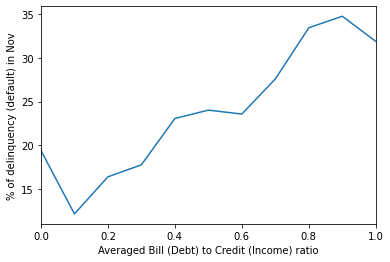

- Higher delinquency (default) rate for higher ratio
*** New feature BILL_TO_CREDIT (Clipping values to between 0 and 1)



In [9]:
df = (data.filter(regex='BILL_AMT[0-9]').replace(0, np.nan).mean(axis=1)/data['LIMIT_BAL']).fillna(0).clip(0,1)

(data[LABEL].groupby((df/0.1).astype(int)*0.1).mean()*100).plot(
    xlim=(0,1),
    xlabel='Averaged Bill (Debt) to Credit (Income) ratio',
    ylabel='% of delinquency (default) in Nov'
)
plt.show()

print('''- Higher delinquency (default) rate for higher ratio
*** New feature BILL_TO_CREDIT (Clipping values to between 0 and 1)
''')
data['BILL_TO_CREDIT'] = df

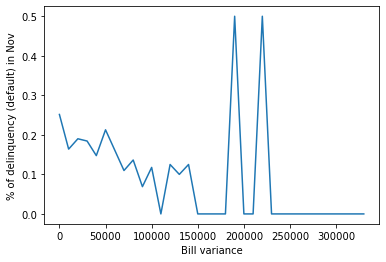

- Higher variance rate for lower delinquency (default) rate
*** New feature BILL_VARIANCE



In [10]:
df = data.filter(regex='BILL_AMT[0-9]').std(axis=1)

data.groupby((df/10000).astype(int)*10000)[LABEL].mean().plot(
    xlabel='Bill variance',
    ylabel='% of delinquency (default) in Nov'
)
plt.show()

print('''- Higher variance rate for lower delinquency (default) rate
*** New feature BILL_VARIANCE
''')

data['BILL_VARIANCE'] = df

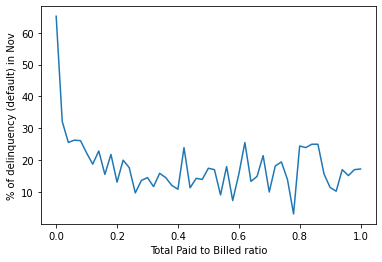

- Higher delinquency (default) rate for lower ratio
*** New feature PAID_TO_BILLED (Clipping values to between 0 and 1)



In [11]:
df1 = data.filter(regex='PAY_AMT[1-5]')
df2 = data.filter(regex='BILL_AMT[2-6]')

df = df1.sum(axis=1)/df2[df2>0].sum(axis=1).fillna(0)
df = df.fillna(1).replace(np.inf, 1).clip(0,1)

(data[LABEL].groupby((df/0.02).astype(int)*0.02).mean()*100).plot(
    xlabel='Total Paid to Billed ratio',
    ylabel='% of delinquency (default) in Nov'
)
plt.show()

print('''- Higher delinquency (default) rate for lower ratio
*** New feature PAID_TO_BILLED (Clipping values to between 0 and 1)
''')
data['PAID_TO_BILLED'] = df

In [12]:
# Save the first dataset
data.to_csv('data_with_new_features.csv', index=False)

## Correlations and distributions visualization

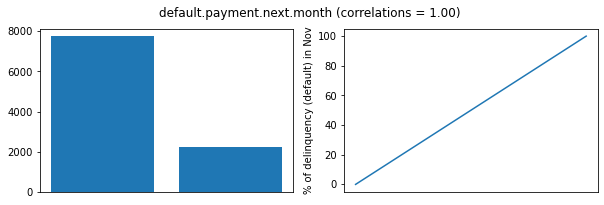

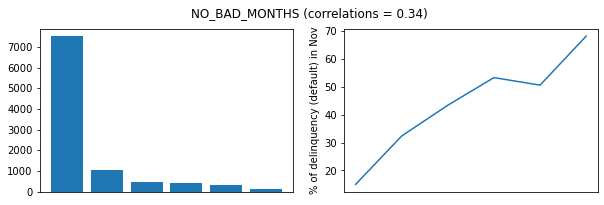

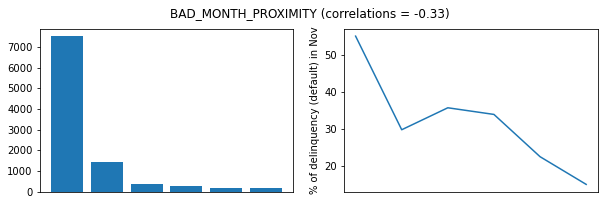

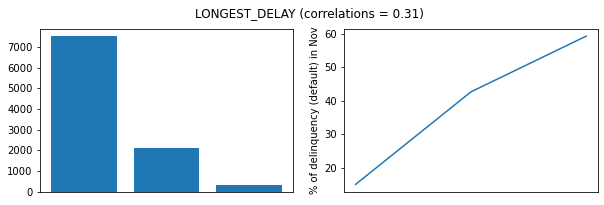

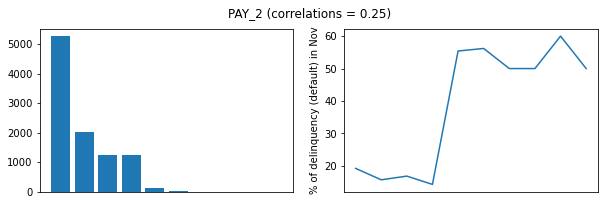

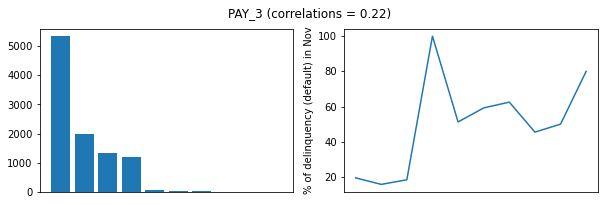

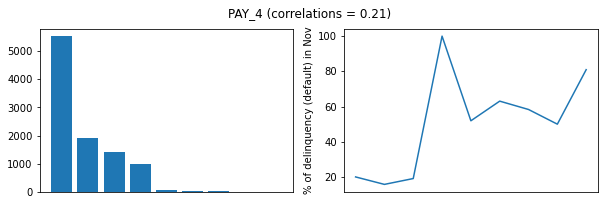

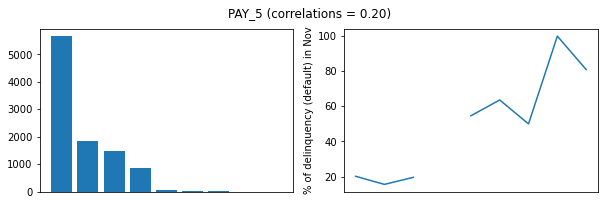

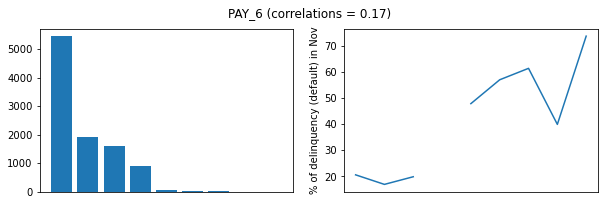

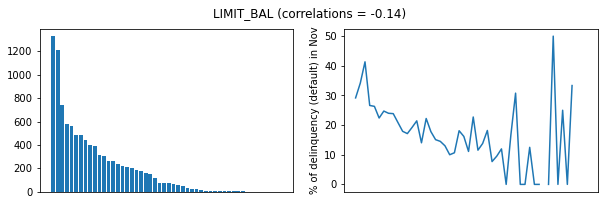

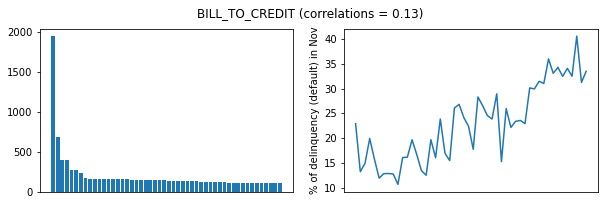

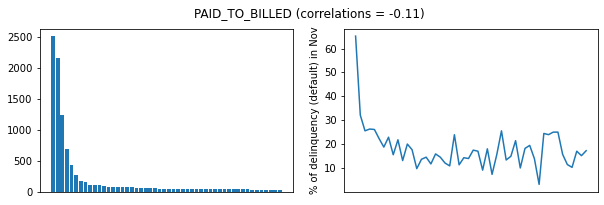

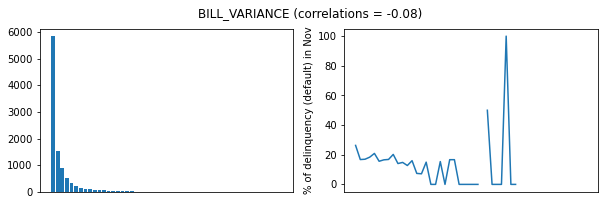

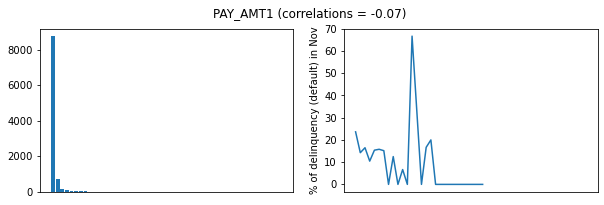

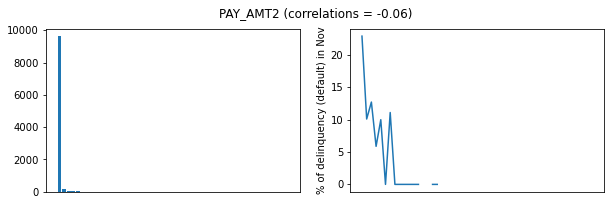

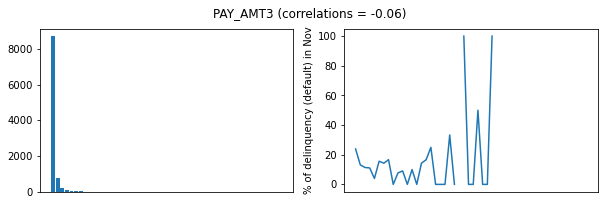

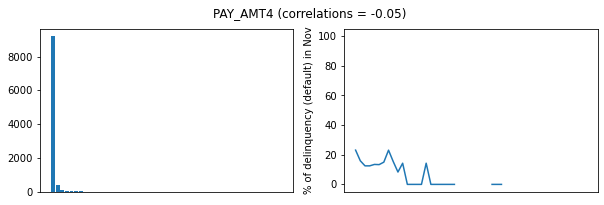

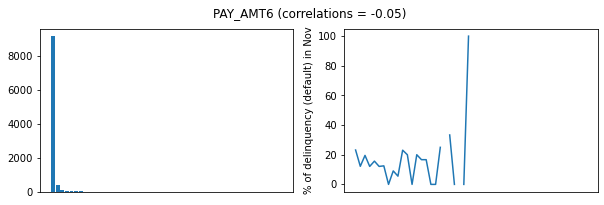

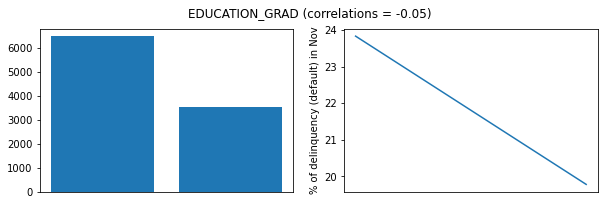

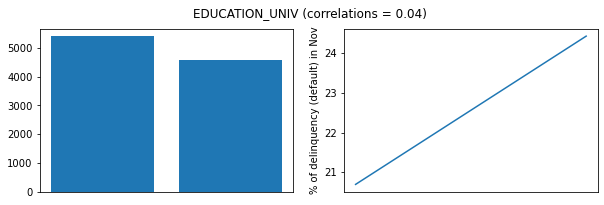

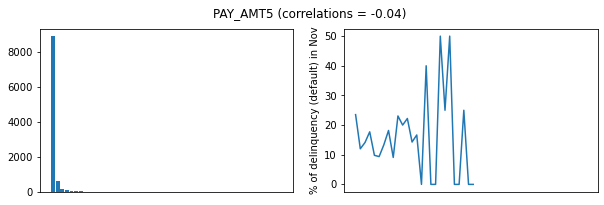

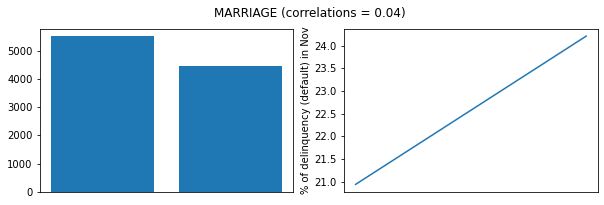

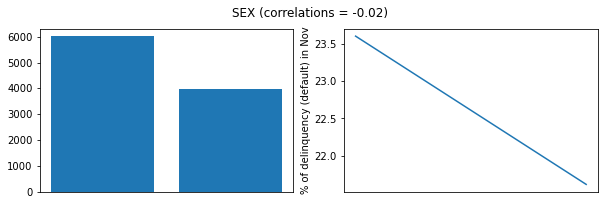

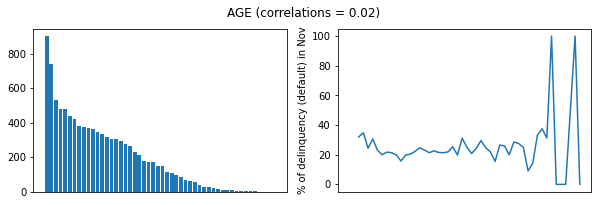

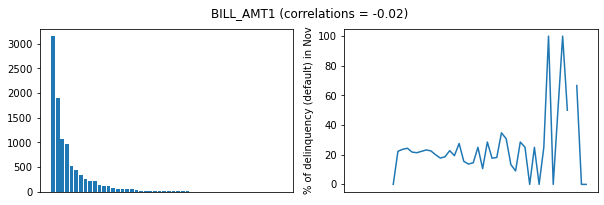

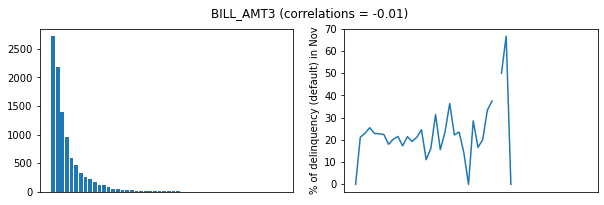

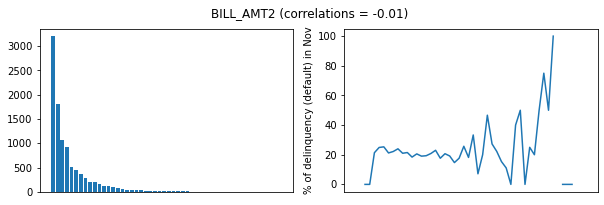

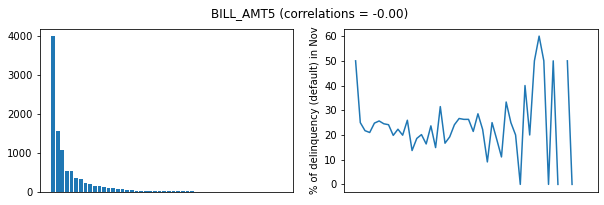

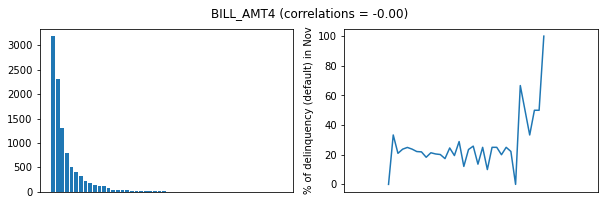

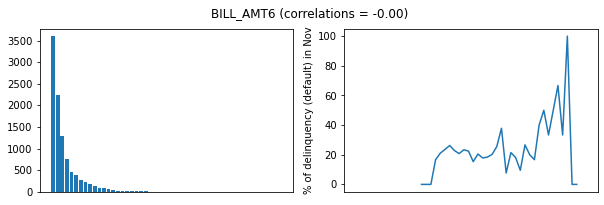

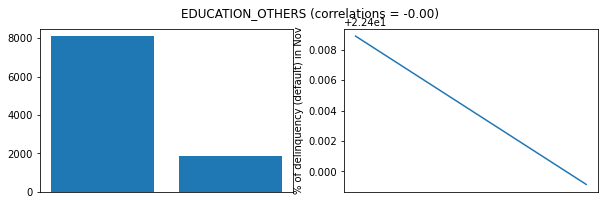

===Shape (9979, 31)
===Portion of delinquency (default) in November 0.22407054815111735


In [13]:
# Visualize correlation and histogram
corr = data.corr()[LABEL]
for feat in corr.abs().sort_values(ascending=False).index:
    groups = pd.cut(data[feat], bins=min(data[feat].nunique(), 50), right=False)
    counts = groups.value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle('%s (correlations = %.2f)'%(feat, corr[feat]))
    
    ax = axes[0]
    ax.bar(np.arange(len(counts)), counts)
    ax.get_xaxis().set_visible(False)
    
    ax = axes[1]
    (data[LABEL].groupby(groups).mean()*100).plot(
        ylabel='% of delinquency (default) in Nov'
    )
    ax.get_xaxis().set_visible(False)
    
    plt.show()
    
# Print final dataset details
print('===Shape', data.shape)
print('===Portion of delinquency (default) in November', data[LABEL].mean())

## Business porfolio
[Back to top](#TOC)

This section is merely for generating a porfolio dataset to estimate the expected ROI of model, and thus not intended to be a full porfolio analysis.

In [14]:
# Two datasets were generated in this EDA

# Data 1: only carries features provided by the raw dataset
data1 = pd.read_csv('data_original_features.csv')

# Data 2: with additional features engineered in this EDA
data2 = pd.read_csv('data_with_new_features.csv')

In [15]:
def get_porfolio(data):
    '''generate a pofolio snapshot for August 2015'''
    aug_pay_status = data['PAY_2']
    
    jul_bill_due = data['BILL_AMT3']
    jul_bill_paid = data['PAY_AMT2']
    jul_bill_overdue = (jul_bill_due - jul_bill_paid).clip(lower=0)
    aug_bill_due = data['BILL_AMT2']
    aug_bill_paid = data['PAY_AMT1']
    aug_bill_overdue = (aug_bill_due - aug_bill_paid).clip(lower=0)
    aug_bill_trans = (aug_bill_due - jul_bill_overdue* (1+OVERDUE_INTEREST)).clip(lower=0)

    portfolio = pd.concat([
        aug_pay_status.rename('aug_pay_status'),
        jul_bill_due.rename('jul_bill_due'),
        jul_bill_paid.rename('jul_bill_paid'),
        jul_bill_overdue.rename('jul_bill_overdue'),
        aug_bill_due.rename('aug_bill_due'),
        aug_bill_paid.rename('aug_bill_paid'),
        aug_bill_trans.rename('aug_bill_trans'),
        aug_bill_overdue.rename('aug_bill_overdue'),
        data[LABEL],
    ], axis=1)

    portfolio['account_status'] = portfolio.apply(
        lambda r: 'overdue_over_3_months' if r['aug_pay_status'] > 3 else
            'inactive' if r['aug_bill_due']<=0 else
            'transactor' if r['jul_bill_overdue']==0 else
            'revolver',
        axis=1
    )
    
    return portfolio

portfolio1 = get_porfolio(data1)
portfolio2 = get_porfolio(data2)

portfolio1.to_csv('data_original_features_portfolio.csv', index=False)
portfolio2.to_csv('data_with_new_features_portfolio.csv', index=False)

In [16]:
p = portfolio1
g = p.groupby('account_status')

display(
    pd.concat([
        g['aug_pay_status'].count().rename(('# cards', 'Total')),
        (g['aug_pay_status'].count()/p['aug_pay_status'].count()*100).rename(('# cards', '%')),
        
        g['aug_bill_overdue'].sum().rename(('Outstanding loan in Aug', 'Total (NT$)')),
        (g['aug_bill_overdue'].sum()/p['aug_bill_overdue'].sum()*100).rename(('Outstanding loan in Aug', '%')),
        g['aug_bill_overdue'].mean().rename(('Outstanding loan in Aug', 'Per Card (NT$)')),
        
        g['aug_bill_trans'].sum().rename(('Transactions in Aug', 'Total (NT$)')),
        (g['aug_bill_trans'].sum()/p['aug_bill_trans'].sum()*100).rename(('Transactions in Aug', '%')),
        g['aug_bill_trans'].mean().rename(('Transactions in Aug', 'Per Card (NT$)')),
        
        g[LABEL].sum().rename(('Delinquent in November 2012', 'Total')),
        (g[LABEL].sum()/p[LABEL].sum()*100).rename(('Delinquent in November 2012', '%')),
        
        (g[LABEL].mean()*100).rename(('Delinquency rate', '%')),
    ], axis=1)\
    .sort_values(('# cards', 'Total'), ascending=False)\
    .style.format('{:,.0f}')
)

print('''
Definitions (in the order of precedence):
- overdue_over_3_months: potentially a real default user who might not pay back ever
- inactive: no transaction on August
- transactor: not carrying balance from July to August
- revolver: carrying balance from July to August
''')


Definitions (in the order of precedence):
- overdue_over_3_months: potentially a real default user who might not pay back ever
- inactive: no transaction on August
- transactor: not carrying balance from July to August
- revolver: carrying balance from July to August

